In [56]:
# OPTIONAL: Load the "autoreload" eX_orig[alias]tension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
import seaborn as sns
import pandas as pd
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
from adjustText import adjust_text
from sklearn.covariance import MinCovDet
from sklearn.manifold import TSNE

from src.util import calculate_difference_to_controls
from src.config import get_hussmann_supplementary_xlsx, get_experiment_artifacts, PAIRED_SAMPLES, SAMPLE
from src.models.outliers import logratio_outlier_detection


# tSNE Visualisations

- Load sample data
- Get actual controls
- Calculate differential profiles
- Plot tsne

In [58]:
Z = pkl.load(open("{}/imputed_adamson_sample_data.pkl".format(get_experiment_artifacts(profile_type=SAMPLE)), "rb"))
d = pd.concat(Z, axis=1)
d.shape

(496, 14)

In [59]:
d.head()

K562_SpCas9_target-1_HDR_oBA701_AX227_rep_1  \
lumc_category                  Deletion 0bp microhomology   
Gene                                                        
Actl6a                                           0.176425   
Actr5                                            0.181376   
Actr8                                            0.190534   
Aicda                                            0.184504   
Alkbh2                                           0.189304   

                                                                     \
lumc_category Deletion 1bp microhomology Deletion 2bp microhomology   
Gene                                                                  
Actl6a                          0.362053                   0.049512   
Actr5                           0.369397                   0.039925   
Actr8                           0.373348                   0.049253   
Aicda                           0.364239                   0.056348   
Alkbh2                          0.356852                   0.054539   

                                                                              \
lumc_category Deletion with insertion Homology Directed Repair Any Insertion   
Gene                                                                           
Actl6a                       0.168670                 0.036964      0.179460   
Actr5                        0.170009                 0.048849      0.160807   
Actr8                        0.166768                 0.049737      0.144000   
Aicda                        0.172529                 0.049311      0.138997   
Alkbh2                       0.170885                 0.051923      0.140536   

                                           \
lumc_category Deletion 3+bp microhomology   
Gene                                        
Actl6a                           0.026915   
Actr5                            0.029638   
Actr8                            0.026359   
Aicda                            0.034072   
Alkbh2                           0.035961   

              K562_SpCas9_target-1_HDR_oBA701_AX227_rep_2  \
lumc_category                  Deletion 0bp microhomology   
Gene                                                        
Actl6a                                           0.188586   
Actr5                                            0.195956   
Actr8                                            0.203623   
Aicda                                            0.195059   
Alkbh2                                           0.193534   

                                                                     \
lumc_category Deletion 1bp microhomology Deletion 2bp microhomology   
Gene                                                                  
Actl6a                          0.371922                   0.056949   
Actr5                           0.370521                   0.048415   
Actr8                           0.374286                   0.055232   
Aicda                           0.369124                   0.063027   
Alkbh2                          0.370191                   0.063229   

                                                                              \
lumc_category Deletion with insertion Homology Directed Repair Any Insertion   
Gene                                                                           
Actl6a                       0.146351                 0.040692      0.160397   
Actr5                        0.160097                 0.047645      0.145036   
Actr8                        0.152378                 0.053022      0.131319   
Aicda                        0.159304                 0.051377      0.127126   
Alkbh2                       0.155718                 0.054698      0.126309   

                                           
lumc_category Deletion 3+bp microhomology  
Gene                                       
Actl6a                           0.035102  
Actr5                            0.032331  
Actr8                            0.

In [60]:
controls = d.index[d.index.str.contains("non-")].to_list()
controls[:5]

['non-targeting_000',
 'non-targeting_001',
 'non-targeting_002',
 'non-targeting_003',
 'non-targeting_005']

In [61]:
Xall = d.stack().stack()\
    .to_frame().reset_index()\
    .rename(columns={"level_2": "Sample", 0: "Value"})\
    .pivot(index=["Sample", "Gene"], columns=["lumc_category"], values="Value")


In [62]:
Xdiff = calculate_difference_to_controls(Xall, controls, d.columns.unique(0))
Xdiff.head()

(992, 7)
(58, 7)
(496, 14)
(14,)
(496, 14)


Sample        K562_SpCas9_target-1_HDR_oBA701_AX227_rep_1  \
lumc_category                               Any Insertion   
Gene                                                        
Actl6a                                           0.039872   
Actr5                                            0.021219   
Actr8                                            0.004412   
Aicda                                           -0.000591   
Alkbh2                                           0.000948   

Sample                                                               \
lumc_category Deletion 0bp microhomology Deletion 1bp microhomology   
Gene                                                                  
Actl6a                         -0.012454                  -0.002015   
Actr5                          -0.007504                   0.005328   
Actr8                           0.001654                   0.009280   
Aicda                          -0.004376                   0.000170   
Alkbh2                          0.000424                  -0.007217   

Sample                                                                \
lumc_category Deletion 2bp microhomology Deletion 3+bp microhomology   
Gene                                                                   
Actl6a                         -0.004580                   -0.006799   
Actr5                          -0.014167                   -0.004077   
Actr8                          -0.004839                   -0.007355   
Aicda                           0.002256                    0.000358   
Alkbh2                          0.000447                    0.002247   

Sample                                                          \
lumc_category Deletion with insertion Homology Directed Repair   
Gene                                                             
Actl6a                       0.000240                -0.014263   
Actr5                        0.001578                -0.002378   
Actr8                       -0.001662                -0.001490   
Aicda                        0.004099                -0.001916   
Alkbh2                       0.002454                 0.000697   

Sample        K562_SpCas9_target-1_HDR_oBA701_AX227_rep_2  \
lumc_category                               Any Insertion   
Gene                                                        
Actl6a                                           0.033544   
Actr5                                            0.018182   
Actr8                                            0.004465   
Aicda                                            0.000273   
Alkbh2                                          -0.000544   

Sample                                                               \
lumc_category Deletion 0bp microhomology Deletion 1bp microhomology   
Gene                                                                  
Actl6a                         -0.009851                  -0.000300   
Actr5                          -0.002481                  -0.001702   
Actr8                           0.005186                   0.002063   
Aicda                          -0.003378                  -0.003098   
Alkbh2                         -0.004903                  -0.002032   

Sample                                                                \
lumc_category Deletion 2bp microhomology Deletion 3+bp microhomology   
Gene                                                                   
Actl6a                         -0.003877                   -0.000394   
Actr5                          -0.012411                   -0.003165   
Actr8                          -0.005594                   -0.005355   
Aicda                           0.002201                   -0.000514   
Alkbh2                          0.002403                    0.000825   

Sample                                                          
lumc_category Deletion with insertion Homology Directed Repair  
Gene                                                            
Actl6a

In [63]:
adamson_data = pd.read_excel(get_hussmann_supplementary_xlsx(4), sheet_name="Table S4", skiprows=1)
adamson_data.head()

,Gene,Plot Annotation,All Annotations,Gene.1,Plot Annotation.1,All Annotations.1
0,ACTL6A,Chromatin processes,"Chromatin remodeling, Histone acetylation, His...",APTX,Double-strand break repair,"Cellular response to DNA damage stimulus, DNA ..."
1,ACTR5,Double-strand break repair,"Cellular response to DNA damage stimulus, Chro...",ASCC3,DNA repair,"Cellular response to DNA damage stimulus, DNA ..."
2,ACTR8,Double-strand break repair,"Cellular response to DNA damage stimulus, Chro...",ATM,Cell cycle checkpoint,"Cell cycle checkpoint, Cellular response to DN..."
3,AICDA,Chromatin processes,"Demethylation, DNA metabolic process, Nucleic ...",ATR,Cell cycle checkpoint,"Cell cycle checkpoint, Cellular response to DN..."
4,ALKBH2,DNA repair,"Cellular response to DNA damage stimulus, Deme...",ATRIP,DNA repair,"Cell cycle checkpoint, Cellular response to DN..."


In [64]:
full_adamson_set = False

if full_adamson_set:
    annotations = "All Annotations"
    genes = "Gene"
else:
    annotations = "All Annotations.1"
    genes = "Gene.1"

pathway_binary_df = adamson_data[annotations].dropna().str.replace(", ", ",").str.get_dummies(sep=",")
pathway_binary_df[genes] = adamson_data[genes].dropna().str.capitalize()
pathway_binary_df = pathway_binary_df.set_index(genes)
pathway_binary_df.head()

,Base-excision repair,Cell cycle checkpoint,Cellular response to DNA damage stimulus,Chromatin remodeling,DNA conformation change,DNA damage checkpoint,DNA metabolic process,DNA repair,DNA replication,DNA replication initiation,...,Postreplication repair,Protein modification process,Protein ubiquitination,RNA biosynthetic process,Regulation of DNA replication,Regulation of transcription by RNA polymerase II,Response to radiation,Sister chromatid segregation,Unclassified,mRNA processing
Gene.1,,,,,,,,,,,,,,,,,,,,,
Aptx,0,0,1,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
Ascc3,0,0,1,0,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
Atm,0,1,1,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Atr,0,1,1,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Atrip,0,1,1,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [65]:
pathway_binary_df.shape

(118, 33)

In [66]:
pathway_binary_df.sum().sort_values()[::-1]

DNA metabolic process                                                 85
Cellular response to DNA damage stimulus                              76
DNA repair                                                            70
DNA replication                                                       37
Double-strand break repair                                            37
Cell cycle checkpoint                                                 18
Nuclear division                                                      18
DNA conformation change                                               18
DNA damage checkpoint                                                 16
Protein modification process                                          16
Nucleic acid phosphodiester bond hydrolysis                           13
Regulation of transcription by RNA polymerase II                      13
RNA biosynthetic process                                              12
Nucleotide-excision repair                         

In [67]:
adamson_genes = list(np.intersect1d(Xdiff.index, pathway_binary_df.index)) 

In [68]:
Xdiff = Xdiff.loc[adamson_genes]

In [69]:
Xdiff.head()

Sample        K562_SpCas9_target-1_HDR_oBA701_AX227_rep_1  \
lumc_category                               Any Insertion   
Gene                                                        
Aptx                                             0.048497   
Ascc3                                            0.018809   
Atm                                             -0.015913   
Atr                                             -0.010631   
Atrip                                            0.007842   

Sample                                                               \
lumc_category Deletion 0bp microhomology Deletion 1bp microhomology   
Gene                                                                  
Aptx                           -0.009479                  -0.027221   
Ascc3                           0.001291                   0.026425   
Atm                            -0.023896                  -0.033155   
Atr                             0.018733                   0.107263   
Atrip                           0.013357                   0.057412   

Sample                                                                \
lumc_category Deletion 2bp microhomology Deletion 3+bp microhomology   
Gene                                                                   
Aptx                            0.000633                   -0.000833   
Ascc3                           0.006318                    0.004463   
Atm                             0.008023                    0.010437   
Atr                             0.004753                    0.003618   
Atrip                           0.012191                    0.010763   

Sample                                                          \
lumc_category Deletion with insertion Homology Directed Repair   
Gene                                                             
Aptx                        -0.009634                -0.001963   
Ascc3                       -0.037028                -0.020277   
Atm                          0.022883                 0.031621   
Atr                         -0.080272                -0.043464   
Atrip                       -0.064634                -0.036931   

Sample        K562_SpCas9_target-1_HDR_oBA701_AX227_rep_2  \
lumc_category                               Any Insertion   
Gene                                                        
Aptx                                             0.036888   
Ascc3                                            0.032572   
Atm                                              0.001639   
Atr                                             -0.004058   
Atrip                                            0.013746   

Sample                                                               \
lumc_category Deletion 0bp microhomology Deletion 1bp microhomology   
Gene                                                                  
Aptx                           -0.010751                  -0.019396   
Ascc3                          -0.006155                   0.005838   
Atm                            -0.021299                  -0.030748   
Atr                             0.020833                   0.091794   
Atrip                           0.002847                   0.047686   

Sample                                                                \
lumc_category Deletion 2bp microhomology Deletion 3+bp microhomology   
Gene                                                                   
Aptx                            0.001563                   -0.001054   
Ascc3                           0.003592                    0.002706   
Atm                             0.002910                    0.011437   
Atr                             0.010239                    0.003360   
Atrip                           0.014042                    0.013369   

Sample                                                          
lumc_category Deletion with insertion Homology Directed Repair  
Gene                                                            
Aptx  

In [70]:
def draw_tsne(data, perplexity=10, n_components=2, title='', hue=None, hue_order=None, labels=None, correct_labels=True, figsize=(6, 5)):
    np.random.seed(42)
    fit = TSNE(
        n_components=n_components,
        init="random",
        random_state=0,
        perplexity=perplexity,
        n_iter=300,
    )
    u = fit.fit_transform(data)
    plot_embedding(u, title=title, hue=hue, hue_order=hue_order, labels=labels, correct_labels=correct_labels, figsize=figsize)
    return u

def plot_embedding(u, title=None, hue=None, hue_order=None, labels=None, correct_labels=True, figsize=(6, 5)):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    sns.scatterplot(x= u[:, 0], y= u[:, 1], ax=ax, hue=hue, hue_order=hue_order, palette="tab10", alpha=0.5)
    if title is not None:
        plt.title(title, fontsize=10.5)
    if labels is not None:
        texts = [plt.text(u[i, 0], u[i, 1], l, fontsize=6) for i, l in enumerate(labels.values) if l != '']
        if correct_labels:
            adjust_text(texts)
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    plt.tight_layout()

def get_labels(Xdiff, labels_to_plot):
    labels = pd.Series(np.repeat("", Xdiff.shape[0]), index=Xdiff.index)
    inter_labels = np.intersect1d(Xdiff.index, labels_to_plot)
    labels[inter_labels] = inter_labels
    return labels

/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


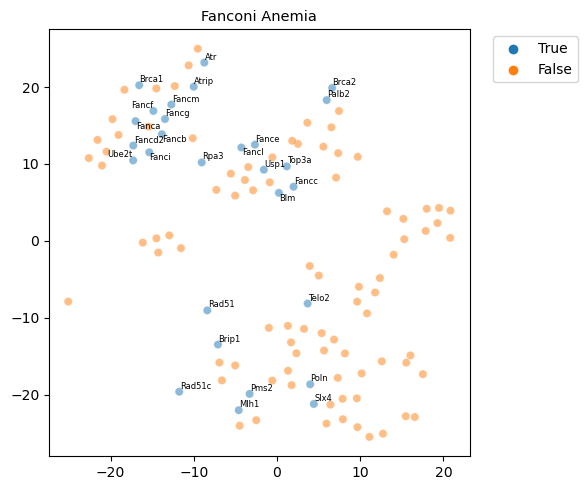

In [71]:
fanconi = ['Atrip', 'Atr', 'Fancm', 'Faap24', 'Cenps', 'Cenpx', 'Telo2', 'Hes1'\
 , 'Faap100', 'Fanca', 'Fancb', 'Fancc', 'Fance', 'Fancf', 'Fancg', 'Fancl'\
    , 'Wdr48', 'Usp1', 'Ube2t', 'Fanci', 'Fancd2', 'Brca2', 'Palb2', 'Rad51c'\
        , 'Rad51', 'Brca1', 'Brip1', 'Fan1', 'Mlh1', 'Pms2', 'Rev1', 'Rev3l', 'Polh'\
            , 'Poli', 'Polk', 'Poln', 'Rmi1', 'Rmi2', 'Top3b', 'Top3a', 'Blm', 'Rpa1', 'Rpa2'\
                , 'Rpa3', 'Mus81', 'Eme1', 'Eme2', 'Ercc4', 'Ercc1', 'Slx1b', 'Slx4']
regex_str = "|".join(fanconi)

u = draw_tsne(Xdiff, perplexity=15, n_components=2,
            title='Fanconi Anemia', 
            hue=Xdiff.index.get_level_values(0).str.contains(regex_str), hue_order=[True, False], labels=get_labels(Xdiff, fanconi))
plt.savefig("artifacts/fanconi_anemia_adamson_tsne_{}.pdf".format("full" if full_adamson_set else "reduced" ))
plt.show()

/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


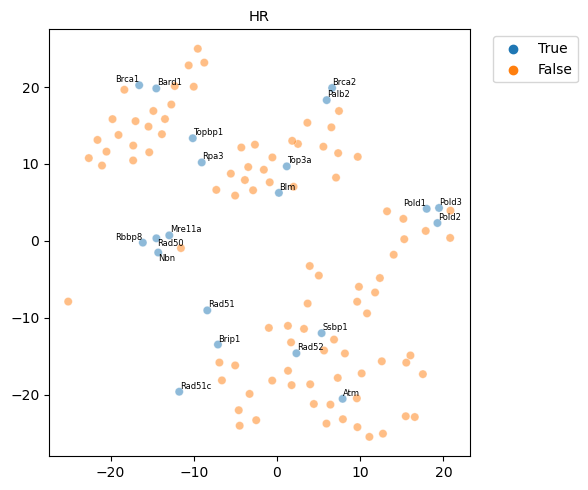

In [72]:
HR = ['Ssbp1', 'Rad50', 'Mre11a', 'Nbn', 'Atm', 'Brca1', 'Bard1', 'Rbbp8', 'Brip1', 'Topbp1'\
      , 'Abraxas1', 'Uimc1', 'Babam1', 'Babam2', 'Brcc3', 'Brcc3dc', 'Palb2', 'Brca2', 'Sem1'\
        , 'Sycp3', 'Rpa1', 'Rpa2', 'Rpa3', 'Rad51', 'Rad52', 'Rad51b', 'Rad51c', 'Rad51d', 'Xrcc2', 'Xrcc3', 'Rad54l'\
      , 'Rad54b', 'Pold1', 'Pold2', 'Pold3', 'Pold4', 'Blm', 'Top3b', 'Top3a', 'Mus81', 'Eme1']
regex_str = "|".join(HR)
u = draw_tsne(Xdiff, perplexity=15, n_components=2, 
            title='HR', 
            hue=Xdiff.index.get_level_values("Gene").str.contains(regex_str), hue_order=[True, False], labels=get_labels(Xdiff, HR))
plt.savefig("artifacts/HR_adamson_tsne_{}.pdf".format("full" if full_adamson_set else "reduced" ))
plt.show()

/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


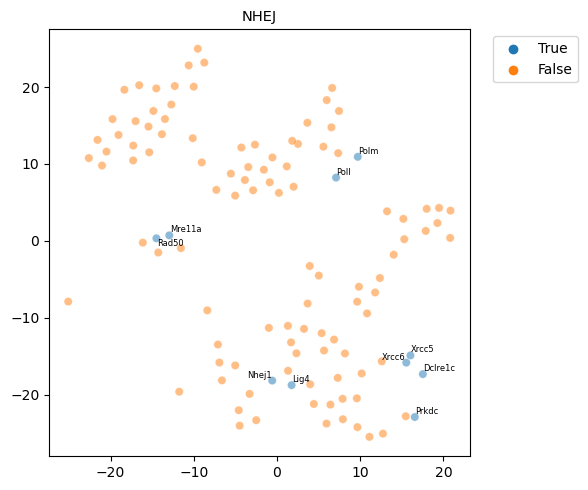

In [73]:
NHEJ = ['Xrcc6', 'Xrcc5', 'Dclre1c', 'Prkdc', 'Poll', 'Polm', 'Dntt', 'Lig4', 'Xrcc4', 'Nhej1', 'Rad50', 'Mre11a', 'Fen1']
regex_str = "|".join(NHEJ)
u = draw_tsne(Xdiff, perplexity=15, n_components=2, 
            title='NHEJ', 
            hue=Xdiff.index.get_level_values("Gene").str.contains(regex_str), hue_order=[True, False], labels=get_labels(Xdiff, NHEJ))
plt.savefig("artifacts/NHEJ_adamson_tsne_{}.pdf".format("full" if full_adamson_set else "reduced" ))
plt.show()

/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


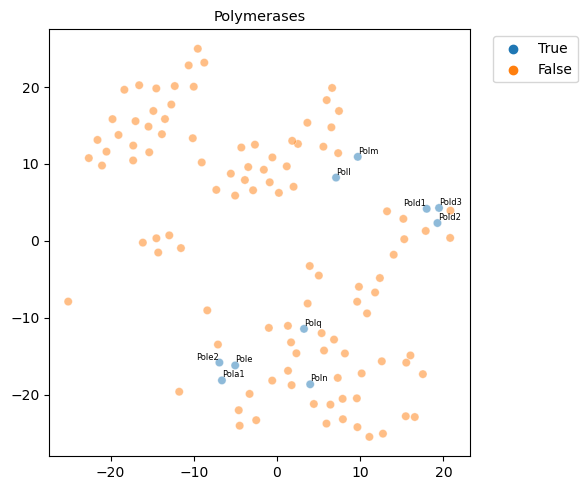

In [74]:
polymerases = ['Polr3a','Pold4','Poln','Polr1c','Pole','Polr3g','Polr3gl','Pole2','Polr2m','Polr2h','Polr2g','Polr1has',
               'Polr2e','Polr3k','Polr2i','Polr3f','Polr1h','Polr1f','Polr1b','Polr2c','Polr2b','Polg2','Pold2','Polb','Pola1',
               'Polr1g','Polr3d','Polq','Polr1a','Polr2j','Pole4','Polr2l','Pold1','Polm','Polr2k','Poll','Polr2a','Polk','Polr2f',
               'Polr1e','Pold3','Polr1d','Polr3b','Polr2d','Polh', 'Polg', 'Poldip3', 'Poldip2', 'Polr3c', 'Pole3','Polrmt','Poli','Pola2','Polr3e','Polr3h']
regex_str = "|".join(polymerases)
u = draw_tsne(Xdiff, perplexity=15, n_components=2, 
            title='Polymerases', 
            hue=Xdiff.index.get_level_values("Gene").str.contains(regex_str), hue_order=[True, False], labels=get_labels(Xdiff, polymerases))
plt.savefig("artifacts/Polymerases_adamson_tsne_{}.pdf".format("full" if full_adamson_set else "reduced" ))
plt.show()

/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/var/folders/5x/n2td64g918lgvdh3qm2x3bhc0000gn/T/ipykernel_24396/1550058790.py:17: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x= u[:, 0], y= u[:, 1], ax=ax, hue=hue, hue_order=hue_order, palette="tab10", alpha=0.5)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


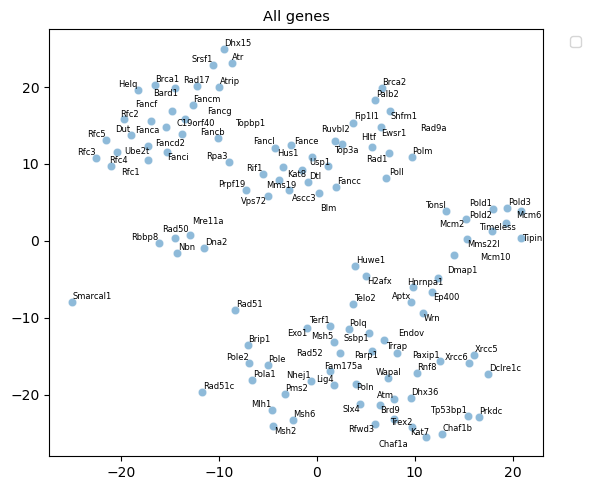

/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/var/folders/5x/n2td64g918lgvdh3qm2x3bhc0000gn/T/ipykernel_24396/1550058790.py:17: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x= u[:, 0], y= u[:, 1], ax=ax, hue=hue, hue_order=hue_order, palette="tab10", alpha=0.5)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


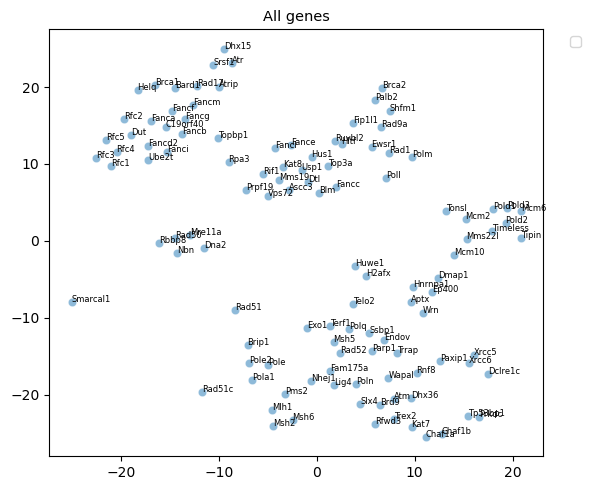

In [75]:
u = draw_tsne(Xdiff, perplexity=15, n_components=2, 
            title='All genes', labels=Xdiff.index.to_series(), correct_labels=True)
plt.show()
u = draw_tsne(Xdiff, perplexity=15, n_components=2, 
            title='All genes', labels=Xdiff.index.to_series(), correct_labels=False)
plt.savefig("artifacts/adamson_tsne_{}.pdf".format("full" if full_adamson_set else "reduced" ))
plt.show()



# Psuedo-controls
- Use psuedo-controls and compare tsnes to above plots

# Data Integration

- Load T2 and T3 target data
- Get difference profiles based on psuedo-controls
- Combine and visualise above plots again

In [76]:
Z = pkl.load(open("{}/imputed_adamson_sample_data.pkl".format(get_experiment_artifacts(profile_type=SAMPLE)), "rb"))
Z.update(pkl.load(open("{}/imputed_sample_data.pkl".format(get_experiment_artifacts(profile_type=SAMPLE)), "rb")))


del Z["MB01"]
del Z["MB02"]
del Z["MB03"]
del Z["MB04"]
# del Z["MB05"]
# del Z["MB06"]

# del Z["T1"]
# del Z["T2"]
# del Z["T3"]
d_paired = pd.concat(Z, axis=1).dropna()
print(d_paired.shape)

(418, 28)


In [77]:
Xall = d_paired.stack().stack()\
    .to_frame().reset_index()\
    .rename(columns={"level_2": "Sample", 0: "Value"})\
    .pivot(index=["Sample", "Gene"], columns=["lumc_category"], values="Value")
Xall.head()

lumc_category                                       Any Insertion  \
Sample                                      Gene                    
K562_SpCas9_target-1_HDR_oBA701_AX227_rep_1 Actl6a       0.179460   
                                            Actr5        0.160807   
                                            Actr8        0.144000   
                                            Aicda        0.138997   
                                            Alkbh2       0.140536   

lumc_category                                       Deletion 0bp microhomology  \
Sample                                      Gene                                 
K562_SpCas9_target-1_HDR_oBA701_AX227_rep_1 Actl6a                    0.176425   
                                            Actr5                     0.181376   
                                            Actr8                     0.190534   
                                            Aicda                     0.184504   
                                            Alkbh2                    0.189304   

lumc_category                                       Deletion 1bp microhomology  \
Sample                                      Gene                                 
K562_SpCas9_target-1_HDR_oBA701_AX227_rep_1 Actl6a                    0.362053   
                                            Actr5                     0.369397   
                                            Actr8                     0.373348   
                                            Aicda                     0.364239   
                                            Alkbh2                    0.356852   

lumc_category                                       Deletion 2bp microhomology  \
Sample                                      Gene                                 
K562_SpCas9_target-1_HDR_oBA701_AX227_rep_1 Actl6a                    0.049512   
                                            Actr5                     0.039925   
                                            Actr8                     0.049253   
                                            Aicda                     0.056348   
                                            Alkbh2                    0.054539   

lumc_category                                       Deletion 3+bp microhomology  \
Sample                                      Gene                                  
K562_SpCas9_target-1_HDR_oBA701_AX227_rep_1 Actl6a                     0.026915   
                                            Actr5                      0.029638   
                                            Actr8                      0.026359   
                                            Aicda                      0.034072   
                                            Alkbh2                     0.035961   

lumc_category                                       Deletion with insertion  \
Sample                                      Gene                              
K562_SpCas9_target-1_HDR_oBA701_AX227_rep_1 Actl6a                 0.168670   
                                            Actr5                  0.170009   
                                            Actr8                  0.166768   
                                            Aicda                  0.172529   
                                            Alkbh2                 0.170885   

lumc_category                                       Homology Directed Repair  
Sample                                      Gene                              
K562_SpCas9_target-1_HDR_oBA701_AX227_rep_1 Actl6a                  0.036964  
                                            Actr5                   0.048849  
                                            Actr8                   0.049737  
                                            Aicda                   0.049311  
                                            Alkbh2                  0.051923

In [78]:
common_genes = Xall.index.get_level_values(1).to_series()
common_genes = np.intersect1d(adamson_genes, common_genes)

In [79]:
common_genes.shape

(102,)

In [80]:
results = {}
pseudo_controls = {}
for alias in Z.keys():
    pca_scores, loadings, explained_variance_ratio, distances, pvalues = logratio_outlier_detection(Z[alias].loc[common_genes], MinCovDet(random_state=0))
    results[alias] = pca_scores, loadings, explained_variance_ratio, distances, pvalues
    results[alias] = pd.Series(distances, index=Z[alias].loc[common_genes].index).sort_values(ascending=False)
    pseudo_controls[alias] = results[alias].iloc[-len(controls):].index.to_series()

In [81]:
Xpseudodiff = {}
for alias in Z.keys():
    Xpseudodiff[alias] = Xall.loc[Xall.index.get_level_values(0) == alias, :]
    Xpseudodiff[alias] = Xpseudodiff[alias].loc[Xpseudodiff[alias].index.get_level_values(1).isin(common_genes)]
    Xpseudodiff[alias] = calculate_difference_to_controls(Xpseudodiff[alias], pseudo_controls[alias], [alias])

(102, 7)
(29, 7)
(102, 7)
(7,)
(102, 7)
(102, 7)
(29, 7)
(102, 7)
(7,)
(102, 7)
(102, 7)
(29, 7)
(102, 7)
(7,)
(102, 7)
(102, 7)
(29, 7)
(102, 7)
(7,)
(102, 7)


In [82]:
Xpseudodiff = pd.concat(Xpseudodiff.values(), axis=1)

In [83]:
mapping_target_to_replicate = {
    "Adamson_T1" : ["K562_SpCas9_target-1_HDR_oBA701_AX227_rep_1", "K562_SpCas9_target-1_HDR_oBA701_AX227_rep_2"],
    "T1": ["MB01", "MB02"],
    "T2": ["MB03", "MB04"],
    "T3": ["MB05", "MB06"],
}

/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


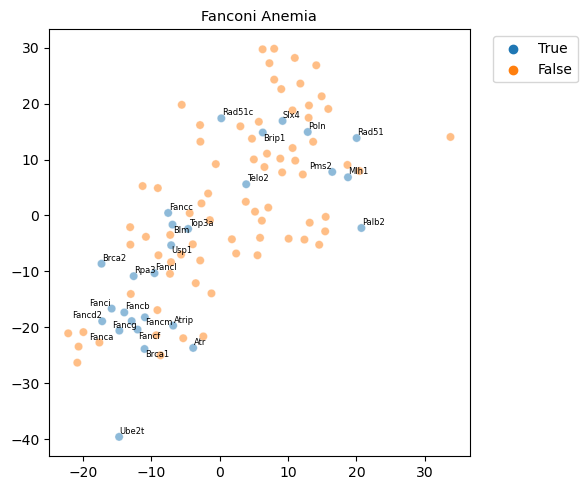

/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


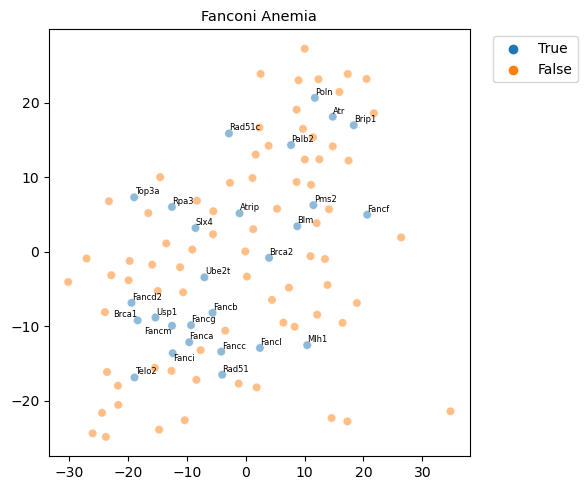

In [92]:
regex_str = "|".join(fanconi)
for alias in ["Adamson_T1", "T3"]:
    tsne_df = Xpseudodiff.loc[:, Xpseudodiff.columns.get_level_values(0).isin(mapping_target_to_replicate[alias])]
    u = draw_tsne(tsne_df, perplexity=15, n_components=2, 
            title='Fanconi Anemia', 
            hue=tsne_df.index.get_level_values(0).str.contains(regex_str), hue_order=[True, False], labels=get_labels(tsne_df, fanconi))
    plt.savefig("artifacts/fanconi_anemia_{}_tsne_{}.pdf".format(alias, "full" if full_adamson_set else "reduced" ))
    plt.show()

/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


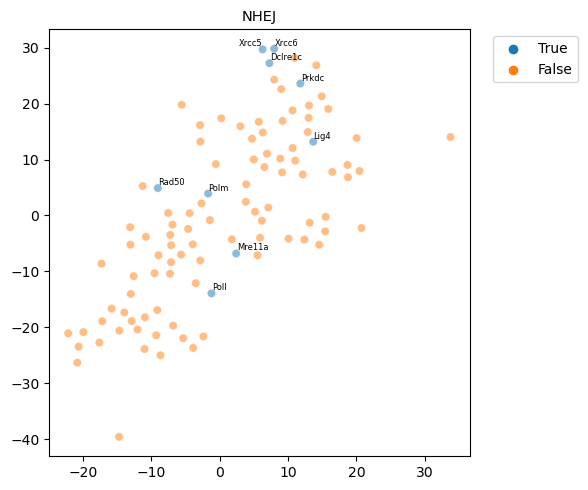

/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


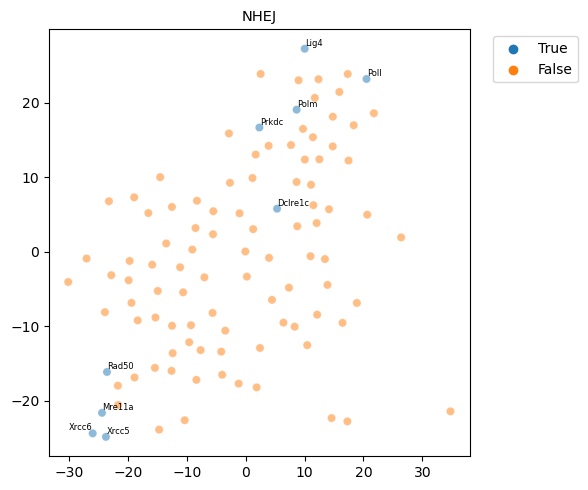

In [93]:
regex_str = "|".join(NHEJ)
for alias in ["Adamson_T1", "T3"]:
    tsne_df = Xpseudodiff.loc[:, Xpseudodiff.columns.get_level_values(0).isin(mapping_target_to_replicate[alias])]
    u = draw_tsne(tsne_df, perplexity=15, n_components=2, 
            title='NHEJ', 
            hue=tsne_df.index.get_level_values(0).str.contains(regex_str), hue_order=[True, False], labels=get_labels(tsne_df, NHEJ))
    plt.savefig("artifacts/NHEJ_{}_tsne_{}.pdf".format(alias, "full" if full_adamson_set else "reduced" ))
    plt.show()

/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


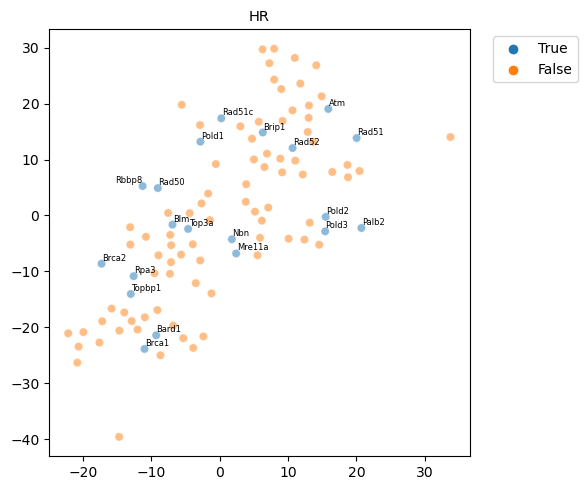

/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


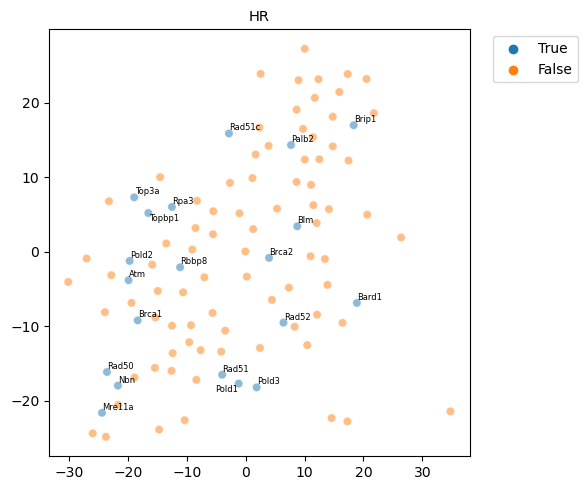

In [94]:
regex_str = "|".join(HR)
for alias in ["Adamson_T1", "T3"]:
    tsne_df = Xpseudodiff.loc[:, Xpseudodiff.columns.get_level_values(0).isin(mapping_target_to_replicate[alias])]
    u = draw_tsne(tsne_df, perplexity=15, n_components=2, 
            title='HR', 
            hue=tsne_df.index.get_level_values(0).str.contains(regex_str), hue_order=[True, False], labels=get_labels(tsne_df, HR))
    plt.savefig("artifacts/HR_{}_tsne_{}.pdf".format(alias, "full" if full_adamson_set else "reduced" ))
    plt.show()

/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


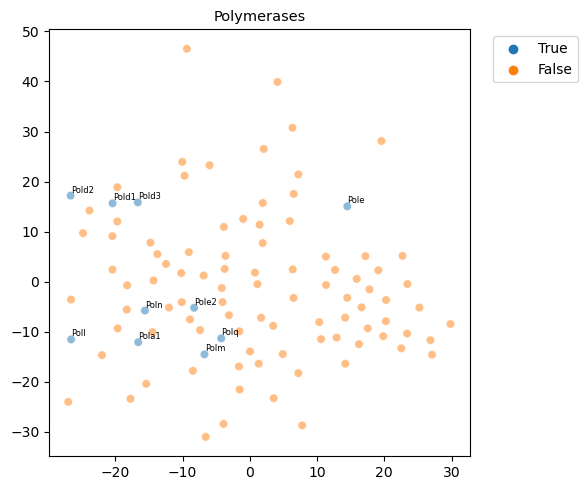

/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


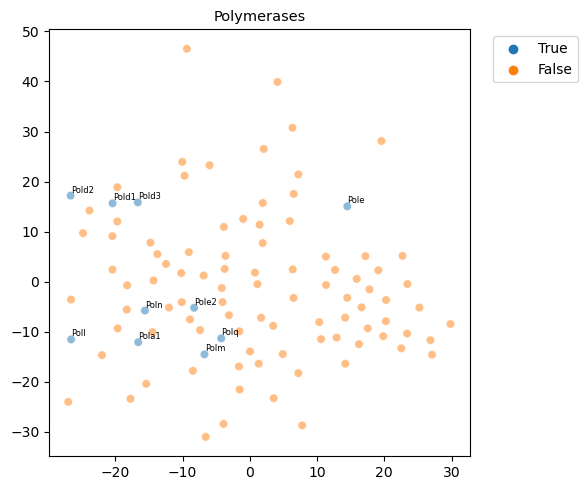

In [87]:
polymerases = ['Polr3a','Pold4','Poln','Polr1c','Pole','Polr3g','Polr3gl','Pole2','Polr2m','Polr2h','Polr2g','Polr1has',
               'Polr2e','Polr3k','Polr2i','Polr3f','Polr1h','Polr1f','Polr1b','Polr2c','Polr2b','Polg2','Pold2','Polb','Pola1',
               'Polr1g','Polr3d','Polq','Polr1a','Polr2j','Pole4','Polr2l','Pold1','Polm','Polr2k','Poll','Polr2a','Polk','Polr2f',
               'Polr1e','Pold3','Polr1d','Polr3b','Polr2d','Polh', 'Polg', 'Poldip3', 'Poldip2', 'Polr3c', 'Pole3','Polrmt','Poli','Pola2','Polr3e','Polr3h']
regex_str = "|".join(polymerases)
for alias in ["Adamson_T1", "T3"]:
    tsne_df = Xpseudodiff.loc[:, Xpseudodiff.columns.get_level_values(0).isin(mapping_target_to_replicate[alias])]
    u = draw_tsne(Xpseudodiff, perplexity=15, n_components=2, 
            title='Polymerases', 
            hue=tsne_df.index.get_level_values(0).str.contains(regex_str), hue_order=[True, False], labels=get_labels(tsne_df, polymerases))
    plt.savefig("artifacts/Polymerases_{}_tsne_{}.pdf".format(alias, "full" if full_adamson_set else "reduced" ))
    plt.show()

In [88]:
for alias in ["Adamson_T1", "T3"]:
    tsne_df = Xpseudodiff.loc[:, Xpseudodiff.columns.get_level_values(0).isin(mapping_target_to_replicate[alias])]
    u = draw_tsne(tsne_df, n_neighbors=15, min_dist=0.1, n_components=2, metric='cosine', 
                title='All genes', labels=tsne_df.index.to_series(), correct_labels=True)
    plt.show()
    u = draw_tsne(tsne_df, n_neighbors=15, min_dist=0.1, n_components=2, metric='cosine', 
                title='All genes', labels=tsne_df.index.to_series(), correct_labels=False)
    plt.savefig("artifacts/adamson_{}_tsne_{}.pdf".format(alias, "full" if full_adamson_set else "reduced" ))
    plt.show()


TypeError: draw_tsne() got an unexpected keyword argument 'n_neighbors'

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


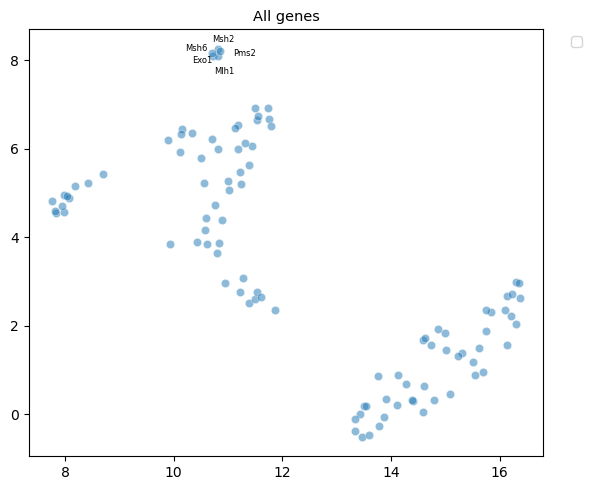

In [ ]:
for alias in ["Adamson_T1"]:
    tsne_df = Xpseudodiff.loc[:, Xpseudodiff.columns.get_level_values(0).isin(mapping_target_to_replicate[alias])]
    u = draw_tsne(Xpseudodiff, perplexity=15, n_components=2, 
                title='All genes', labels=get_labels(tsne_df, ["Mlh1", "Msh2", "Msh6", "Pms2", "Exo1"]), correct_labels=True)
    plt.show()